In [3]:
import sys
sys.path.append('/home/yungdankblast/DelayedOptimization/delay-optimizer')
from FuncOptHandler import Handler
import numpy as np
from Optimizer_Scripts.DelayTypeGenerators import Undelayed, Uniform, Stochastic, Partial
from Optimizer_Scripts.Data import Data

## Create Table of Hyperparameters

In [4]:
def get_filename(loss_name, d, file_tag):
    return f"Data/{loss_name}{d}d_{file_tag}.dat"

def load(loss_name, d, file_tag):
    filename = get_filename(loss_name, d, file_tag)
    return Data.load(filename)

In [11]:
# Constant learning rate hyperparameters
loss_names = ['Ackley', 'Rastrigin', 'Rosenbrock', 'Zakharov']
dimensions = [2, 10, 100, 1000]
file_tags = ["optimal_undel", "optimal_stochL1"]
delay_types = ["undelayed", "stochastic"]

with open ("Data/hyperparameters.csv", "w") as outfile:
    outfile.write("loss_name,dim,delay_type,lr_type,lr_range_lower,lr_range_upper,learning_rate,min_lr_range_lower,min_lr_range_upper,min_lr,max_lr_range_lower,max_lr_range_upper,max_lr,step_size_range_lower,step_size_range_upper,step_size,gamma_range_lower,gamma_range_upper,gamma,p_range_lower,p_range_upper,p\n")
    for loss_name in loss_names:
        for i, file_tag in enumerate(file_tags):
            for d in dimensions:
                data = load(loss_name, d, file_tag)
                learning_rate = data.lr_params["learning_rate"]
                outfile.write(f"{loss_name},{d},{delay_types[i]},const,,,{learning_rate},,,,,,,,,,,,,,,\n")

# Decaying learning rate hyperparameters
loss_names = ['Ackley', 'Zakharov']
dimensions = [1000]
lr_types = ["sin-2", "tri-2", "inv"]
file_tags = ["optimal_undel", "optimal_stochL1"]
delay_types = ["undelayed", "stochastic"]

with open ("Data/hyperparameters.csv", "a") as outfile:
    for loss_name in loss_names:
        for i, tag in enumerate(file_tags):
            for d in dimensions:
                for lr_type in ["sin2", "tri2"]:
                    file_tag = f"{tag}_{lr_type}" 
                    data = load(loss_name, d, file_tag)
                    max_lr = data.lr_params["max_lr"]
                    min_lr = data.lr_params["min_lr"]
                    step_size = data.lr_params["step_size"]
                    outfile.write(f"{loss_name},{d},{delay_types[i]},{lr_type},,,,,,{min_lr},,,{max_lr},,,{step_size},,,,,,\n")

                lr_type = "inv"
                file_tag = f"{tag}_{lr_type}" 
                data = load(loss_name, d, file_tag)
                max_lr = data.lr_params["max_lr"]
                gamma = data.lr_params["gamma"]
                p = data.lr_params["p"]
                outfile.write(f"{loss_name},{d},{delay_types[i]},{lr_type},,,,,,,,,{max_lr},,,,,,{gamma},,,{p}\n")

## Near Minimum Trials

In [5]:
import Optimizer_Scripts.learning_rate_generator as lrgen
from Optimizer_Scripts.Delayer import Delayer
from Optimizer_Scripts import optimizers
import warnings
import pathos.multiprocessing as multiprocessing
from tqdm import tqdm

class StabilityHandler(Handler):
    """Function optimization handler that overwrites the run and optimize methods in order to set delayer parameters"""
    def __init__(self, loss_name, dim):
        super().__init__(loss_name, dim)

    def gen_points_near_min(self, num_points, radius):
        """Generate points near the minimum of a given function"""
        minimizer = self.loss_func.minimizer
        self.x_inits = np.random.uniform(minimizer-radius, minimizer+radius, 
                                         size=(num_points, self.loss_func.n))
    
    def _get_optimizer(self, optimizer_name, beta_1=0.9, beta_2=0.999, **lr_params):
        """Initialize parameters and return the optimizer object."""
        if optimizer_name == 'Adam':
            params = {
                'beta_1': beta_1, 
                'beta_2': beta_2,
                'learning_rate': lrgen.generate_learning_rates(**lr_params)
                }
            return optimizers.Adam(params)
        else:
            raise ValueError("Invalid optimizer name.") 

    def _get_delayer(self, delay_type, loss_func, optimizer, save_state, save_loss, save_grad):
        """Initialize and return the Delayer object."""
        return Delayer(delay_type, loss_func, optimizer, save_state, save_loss, save_grad) 
    
    @staticmethod
    def run(x, delayer, maxiter, tol, break_opt):
        """Run optimization on a single point"""
        return delayer.optimize(x, maxiter, tol, break_opt)
    
    def optimize(self, delay_type, lr_type, optimizer_name="Adam", maxiter=5000, 
                 tol=1e-5, break_opt=True, save_loss=True, save_grad=False, 
                 save_state=(0,1), processes=None, **lr_kwargs):
        """Run the optimization on the initial points already initialized and 
        saves values to be plotted.
        
        Parameters:
            delay_type(DelayType): class object containing delay parameters
            optimizer_name(str): the name of the optimizer to use
            maxiter(int): the maximum number of iterations for optimization
            tol(float): the tolerance value for optimization
            break_opt(bool): whether optimization should stop when convergence 
                             criteria is met
            save_state(bool/tuple): state dimensions to save during optimization
            save_loss(bool): whether to save loss values over time 
            save_grad(bool): whether to save gradient values over time
        """
        # Check if points have been initialized
        if len(self.x_inits) == 0:
            warnings.warn("No points have been initialized.")
            return
        
        # Initialize
        lr_params = self.get_lr_params(lr_type, **lr_kwargs)
        optimizer = self._get_optimizer(optimizer_name, **lr_params)
        delayer = self._get_delayer(delay_type, self.loss_func, optimizer, 
                                    save_state, save_loss, save_grad)

        # Set up data object
        self.data = Data(self.loss_func)
        self.data.set_delay_scheme(delay_type, maxiter, tol, break_opt)
        self.data.set_optimizer_params(optimizer_name, lr_params)
            
        # Parallelize and optimize for each initial point
        task = lambda x: StabilityHandler.run(x, delayer, maxiter, tol, break_opt)
        
        pbar = tqdm(total=len(self.x_inits), 
                    desc=r"{} {}d ({})".format(self.loss_func.loss_name, 
                                               self.loss_func.n,
                                               delay_type.delay_type), 
                    leave=True)
        for point in self.x_inits:
            result = task(point)
            self.data.add_point(result, save_state, save_loss, save_grad)
            pbar.update(1)
            
        return self.data


In [207]:
ackley = StabilityHandler('ackley', 2)
ackley.gen_points_near_min(5, 1.)
undelayed_data = ackley.optimize(Undelayed(), "const", learning_rate=1.85721428571429)
delayed_data = ackley.optimize(Stochastic(1, 5000), "const", learning_rate=1.33067690501033)

ackley 2d (undelayed):   0%|          | 0/5 [00:00<?, ?it/s]

ackley 2d (stochastic): 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


In [6]:
from matplotlib import pyplot as plt

def plot_path(minimizer, data, point=0):
    plt.figure(figsize=(10,10))
    path = data.state_vals[point]
    plt.plot(*path.T)
    plt.scatter(path[0,0], path[0,1], c="g", zorder=10)
    plt.scatter(path[-1,0], path[-1,1], c="r", zorder=10)
    plt.scatter(*minimizer, c="k", label="Minimizer", zorder=10)
    plt.gca().set_aspect("equal", "box")
    plt.legend()
    plt.show()

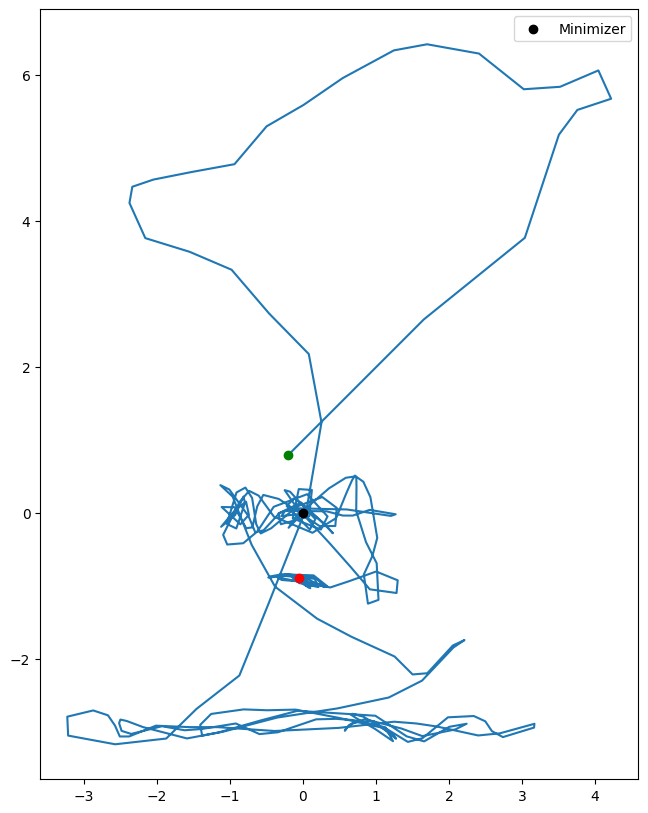

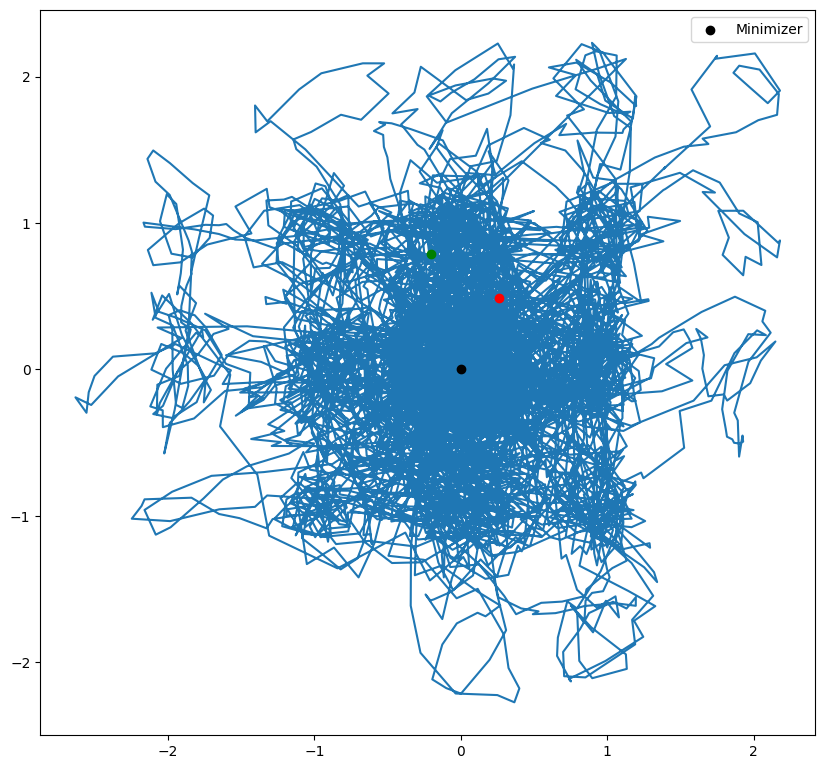

In [209]:
plot_path(ackley.loss_func.minimizer, undelayed_data)
plot_path(ackley.loss_func.minimizer, delayed_data)

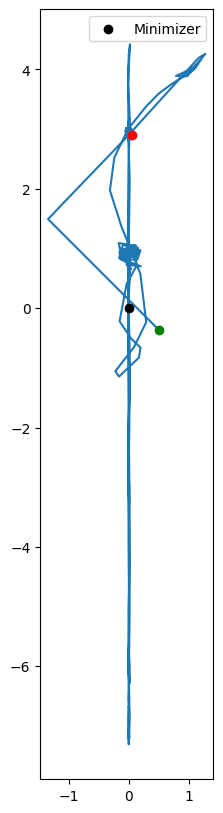

In [205]:
plot_path(ackley.loss_func.minimizer, undelayed_data)

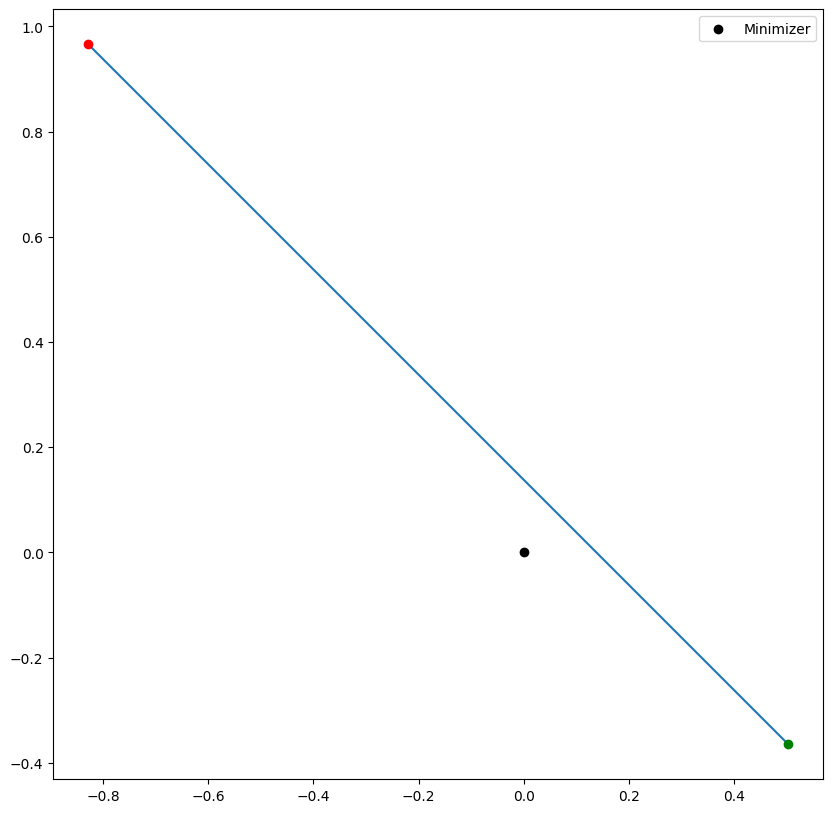

In [206]:
plot_path(ackley.loss_func.minimizer, delayed_data)

rastrigin 2d (stochastic): 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


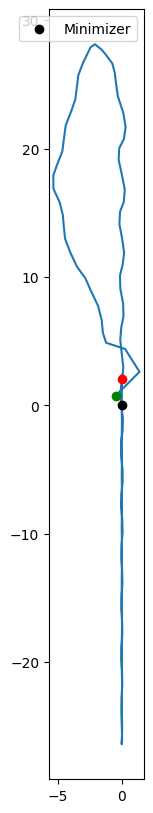

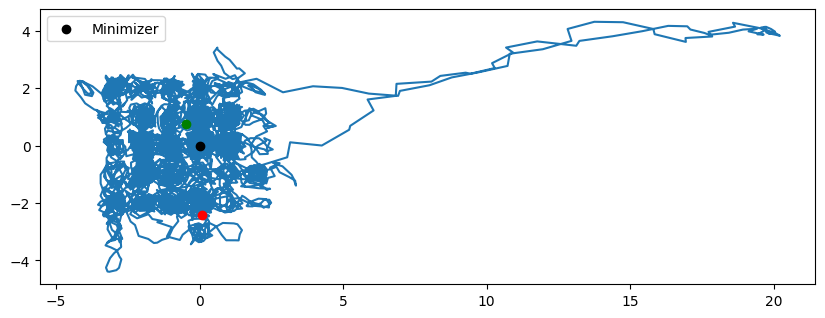

In [142]:
rast = StabilityHandler('rastrigin', 2)
rast.gen_points_near_min(1, 1.)
undelayed_data = rast.optimize(Undelayed(), "const", learning_rate=1.85721428571429)
delayed_data = rast.optimize(Stochastic(1, 5000), "const", learning_rate=1.33067690501033)

plot_path(rast.loss_func.minimizer, undelayed_data)
plot_path(rast.loss_func.minimizer, delayed_data)

### Closer $\left(\epsilon=0.1\right)$

In [7]:
ackley = StabilityHandler('ackley', 2)
ackley.gen_points_near_min(5, 0.1)
undelayed_data = ackley.optimize(Undelayed(), "const", learning_rate=1.85721428571429)
delayed_data = ackley.optimize(Stochastic(1, 5000), "const", learning_rate=1.33067690501033)

ackley 2d (undelayed):   0%|          | 0/5 [00:00<?, ?it/s]

ackley 2d (stochastic): 100%|██████████| 5/5 [00:01<00:00,  3.20it/s]


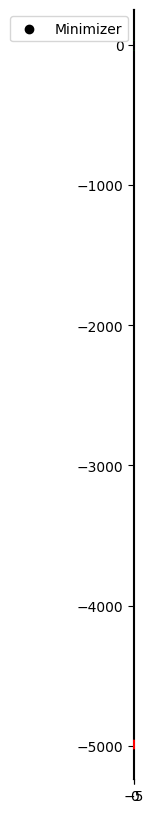

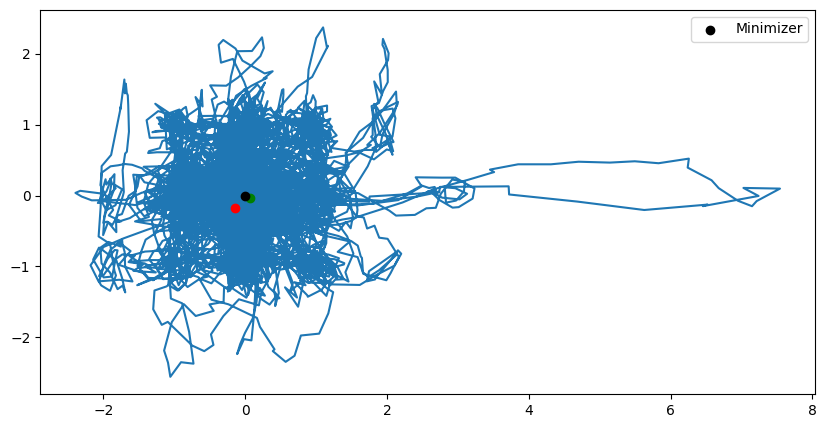

In [8]:
plot_path(ackley.loss_func.minimizer, undelayed_data)
plot_path(ackley.loss_func.minimizer, delayed_data)

### Closest $\left(\epsilon=0.00001\right)$

In [11]:
ackley = StabilityHandler('ackley', 2)
ackley.gen_points_near_min(5, 0.00001)
undelayed_data = ackley.optimize(Undelayed(), "const", learning_rate=1.85721428571429)
delayed_data = ackley.optimize(Stochastic(1, 5000), "const", learning_rate=1.33067690501033)

ackley 2d (stochastic): 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]


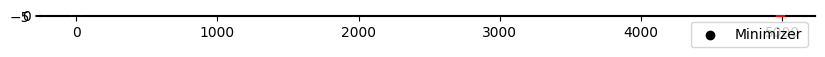

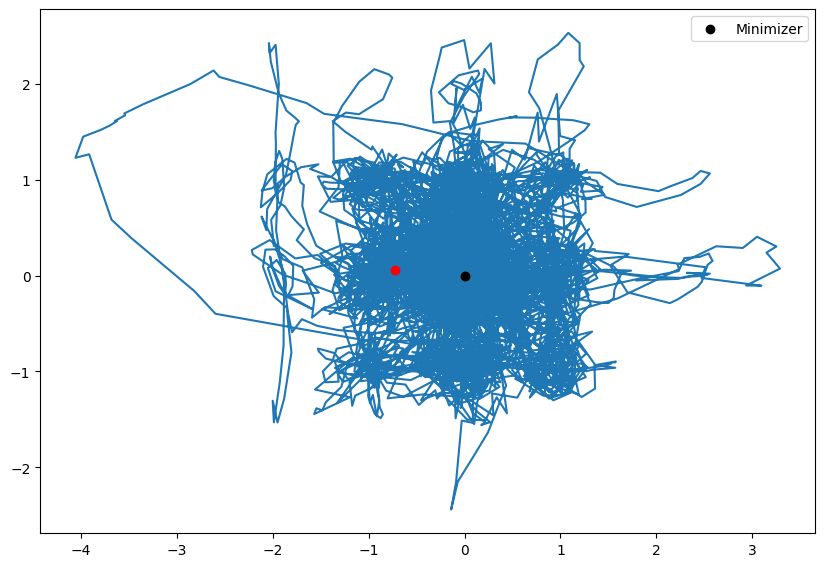

In [12]:
plot_path(ackley.loss_func.minimizer, undelayed_data)
plot_path(ackley.loss_func.minimizer, delayed_data)

In [13]:
ackley = StabilityHandler('ackley', 2)
ackley.gen_points_near_min(5, 0.00001)
undelayed_data = ackley.optimize(Undelayed(), "const", learning_rate=1.85721428571429)
delayed_data = ackley.optimize(Stochastic(1, 5000), "const", learning_rate=1.33067690501033)

ackley 2d (stochastic): 100%|██████████| 5/5 [00:02<00:00,  1.93it/s]


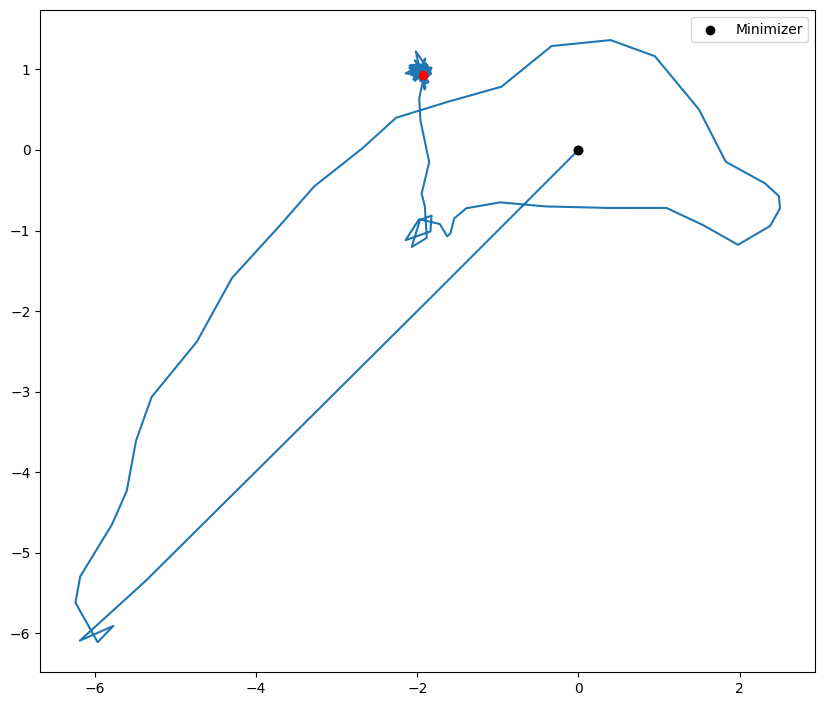

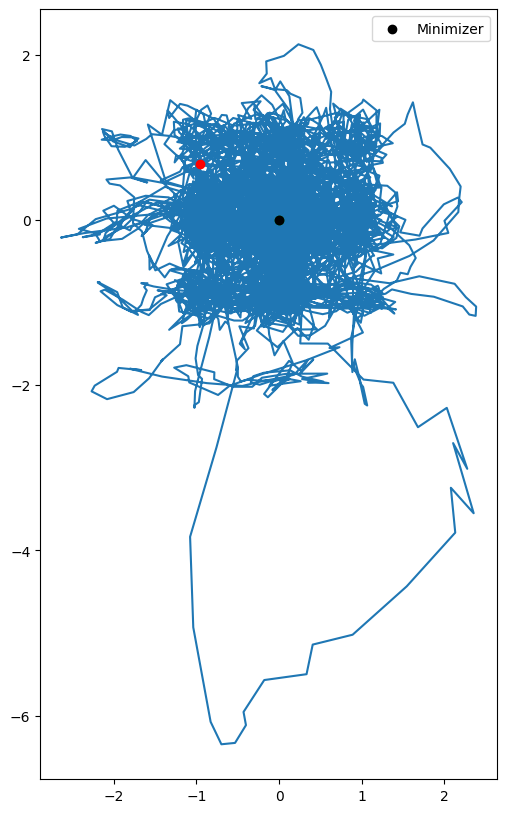

In [14]:
plot_path(ackley.loss_func.minimizer, undelayed_data)
plot_path(ackley.loss_func.minimizer, delayed_data)

### Near $\left(\epsilon=1.\right)$ with smaller LR $\left(\alpha=0.5\right)$

In [31]:
ackley = StabilityHandler('ackley', 2)
ackley.gen_points_near_min(5, 1)
undelayed_data = ackley.optimize(Undelayed(), "const", learning_rate=0.7)
delayed_data = ackley.optimize(Stochastic(1, 5000), "const", learning_rate=0.7)

ackley 2d (stochastic): 100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


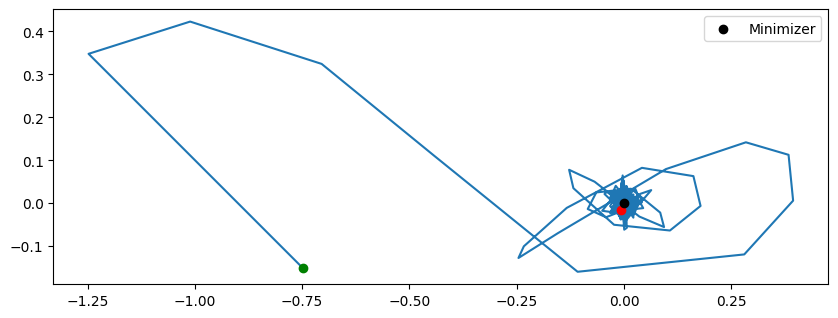

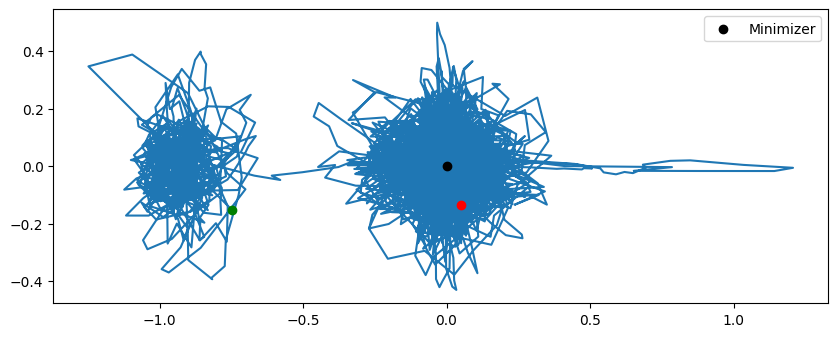

In [30]:
plot_path(ackley.loss_func.minimizer, undelayed_data)
plot_path(ackley.loss_func.minimizer, delayed_data)

## Keep epsilon within 0.01, keep learning rate small (1e-4 start)

* From me, maybe look at starting from a point where the gradient is less than 1
* Experiment with different $m$ and $v$ values